# Frozen Lake

This notebook follows [Jeff Heaton](https://www.youtube.com/watch?v=A3sYFcJY3lA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) presentation on RL.

In [2]:
import seaborn as sns
import pandas as pd

In [3]:
import gymnasium as gym
import numpy as np
import PIL.Image

Frozen Lake is the simulation evironment for training Reinforcement Learning Agent. 

It is simplistic environment with small number of actions and states.

In [4]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=False)

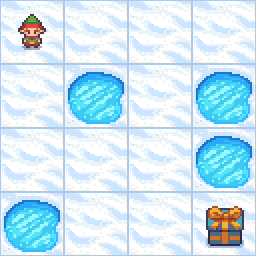

In [5]:
env.reset()
PIL.Image.fromarray(env.render())

The task consists in the crossing a frozen lake from start to end without falling into any holes. 

The player may not always move in the intended direction due to the slippery nature of the frozen lake.

The environment provides the following discrete actions:

* 0 - Move left
* 1 - Move down
* 2 - Move right
* 3 - Move up

The state(observation) is the position on 4x4 map.

The lake is slippery (unless disabled) so the player may move perpendicular to the intended direction sometimes.

The episode ends if the following happens:

 * Moves into a hole

 * Reached the goal at max(nrow) * max(ncol) - 1 (location [max(nrow)-1, max(ncol)-1]).

The walk through lake to the final position can take at least up to 6 steps ...

In [69]:
_ = env.reset()
optimal_steps = [1,1,2,2,1,2]
[env.step(i) for i in optimal_steps]

[(4, 0.0, False, False, {'prob': 1.0}),
 (8, 0.0, False, False, {'prob': 1.0}),
 (9, 0.0, False, False, {'prob': 1.0}),
 (10, 0.0, False, False, {'prob': 1.0}),
 (14, 0.0, False, False, {'prob': 1.0}),
 (15, 1.0, True, False, {'prob': 1.0})]

In this optinal sequence of the steps we start from state 0, then take one step down that brings us to state 8 and so on until we finish at  position 15.

At each step we obtain data: new state (observation), reward, terminated, truncated, info(probability of the next state).

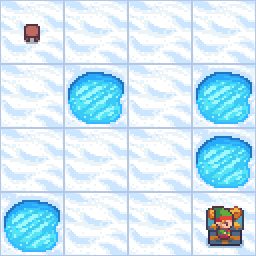

In [7]:
PIL.Image.fromarray(env.render())

The goal of Q-learner is to learn what action(step) to take by calculating maximum reward of the next state.

## Q-learning

Q-Learning is a system of rewards that the algorithm gives an agent for successfully moving the environment into a state considered successful. 

These rewards are the Q-values from which this algorithm takes its name. 

The final output from the Q-Learning algorithm is a table of Q-values that indicate the reward value of every action that the agent can take, given every possible environment state.

$Q^{new}(s_{t},a_{t}) \leftarrow \underbrace{Q(s_{t},a_{t})}_{\text{old value}} + \underbrace{\alpha}_{\text{learning rate}} \cdot  \overbrace{\bigg( \underbrace{\underbrace{r_{t}}_{\text{reward}} + \underbrace{\gamma}_{\text{discount factor}} \cdot \underbrace{\max_{a}Q(s_{t+1}, a)}_{\text{estimate of optimal future value}}}_{\text{new value (temporal difference target)}} - \underbrace{Q(s_{t},a_{t})}_{\text{old value}} \bigg) }^{\text{temporal difference}}$

To learn Q-values, we run episode utill it terminates and at each step, we update Q-table.

In [32]:
def q_learner(env):

    success_count = 0
    epsilon = 1
    
    for episode in range(EPISODES):
        
        # Reset environment to initial position
        state, _ = env.reset()
        terminated = False
    
        while not terminated:

            # Chose an action: explore or exploit
            if np.random.random() > epsilon:
                # Exploit - use q-table to take current best action
                action = np.argmax(QVALUES[state])
            else:
                # Explore -> at random
                action = env.action_space.sample()
            
            # Take an action
            new_state, reward, terminated, _, _ = env.step(action)

            # Update q_values
            max_future_q = np.max(QVALUES[new_state])
            current_q = QVALUES[state][action]
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            QVALUES[state][action] = new_q

            # Update state
            state = new_state
            
            # Has the elf reached the final position?
            if new_state == 15:
                success_count += 1
        
        # Move epsilon towards its ending value, if it still needs to move
        if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
            epsilon_change = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
            epsilon = max(0, epsilon - epsilon_change)
            
        if episode % DISPLAY_INTERVAL == 0:
            print(f"""episode: {episode}, successv{success_count},epsilon: {epsilon}""")

    # Show elf position at the end of the episode
    return PIL.Image.fromarray(env.render())

* **LEARNING_RATE** The rate at which previous Q-values are updated based on new episodes run during training. 
* **DISCOUNT** The amount of significance to give estimates of future rewards when added to the reward for the current action taken. A value of 0.95 would indicate a discount of 5% on the future reward estimates. 
* **EPISODES** The number of episodes to train over. Increase this for more complex problems; however, training time also increases.
* **DISPLAY_INTERVAL** How many episodes to allow to elapse before showing an update.
* **START_EPSILON_DECAYING** Epsilon is the probability that the agent will select a random action over what the Q-Table suggests. This value determines the starting probability of randomness.
* **END_EPSILON_DECAYING** How many episodes should elapse before epsilon goes to zero and no random actions are permitted. For example, EPISODES//10  means only the first 1/10th of the episodes might have random actions.

In [48]:
EPISODES = 1000
DISPLAY_INTERVAL = 10

LEARNING_RATE = 0.01
DISCOUNT = 0.95

START_EPSILON_DECAYING = 0.5
END_EPSILON_DECAYING = EPISODES//100

# initialize Q values
QVALUES = np.zeros([env.observation_space.n, env.action_space.n])

In [ ]:
q_learner(env)

Vizualisation of Q table, where the row is the state and the columns are actions.

To reach the goal we should take an action with the highiest Q-value.

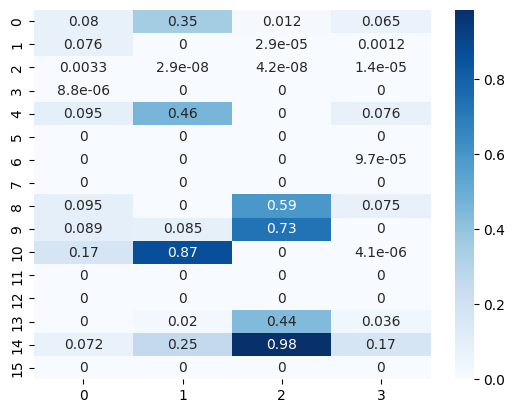

In [50]:
_ = sns.heatmap(pd.DataFrame(QVALUES), annot=True, cmap='Blues')

Let's use learned QVALUES to walk through the lake.

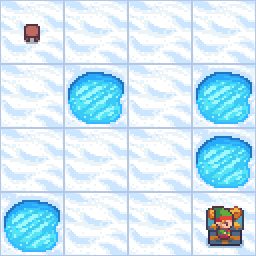

In [62]:
state, _ = env.reset()
terminated = False
actions = []
while not terminated:
    action = np.argmax(QVALUES[state])
    actions.append(action)
    state, reward, terminated, _, _ = env.step(action)

PIL.Image.fromarray(env.render())

In [68]:
actions == optimal_steps

True

The Q-learner learned exactly the same sequence of steps as we defined in optimal_steps.